# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


In [2]:
# !pip install contractions
# !pip install torchtext

# Loading dataset

In [3]:
root = os.getcwd()
#yelp polarity has 2 labels, 
#yelp dataset has 5 labels, they have the same text content
train_datapath = os.path.join(root, 'dataset', 'yelp_polarity', 'train.csv') 
test_datapath = os.path.join(root,  'dataset', 'yelp_polarity', 'test.csv') 

assert os.path.exists(train_datapath),  f"train dataset path {train_datapath} not found"
assert os.path.exists(test_datapath),   f"test dataset path {test_datapath} not found"

sample_size = 0.5

In [4]:
train_df = pd.read_csv(train_datapath, names = ["review","text"])
train_df = train_df.sample(frac = sample_size)
print(train_df.shape)
train_df.reset_index(inplace=True, drop = True)
train_df.head()

(280000, 2)


,review,text
0,1,I am only give it two stars because they did h...
1,1,It's been a long time since I was lured to thi...
2,1,Rip-off artists.\n\n I only used them cuz they...
3,2,"YUM! Finally, a place we like. This place is..."
4,1,"This place has the location down, that's for s..."


# Cleaning

In [5]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [6]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df.head()

,review,text
0,1,give two stars good guacamole rest food would ...
1,1,long time since lured place sweet location ayc...
2,1,rip artists used cuz cheaper dental plan aetna...
3,2,yum finally place like place really clean pret...
4,1,place location sure food terrible ingredients ...


# A little EDA

In [7]:
# wordcloud of common words
freq = collections.Counter()

for row in eda_df.iterrows():
    label, text = row[1]
    freq.update(text.split())

print('most frequent words')
print(freq.most_common(10))


most frequent words
[('food', 164930), ('place', 161067), ('good', 150570), ('would', 139053), ('like', 131241), ('get', 118390), ('one', 118292), ('time', 108493), ('great', 105250), ('service', 104214)]


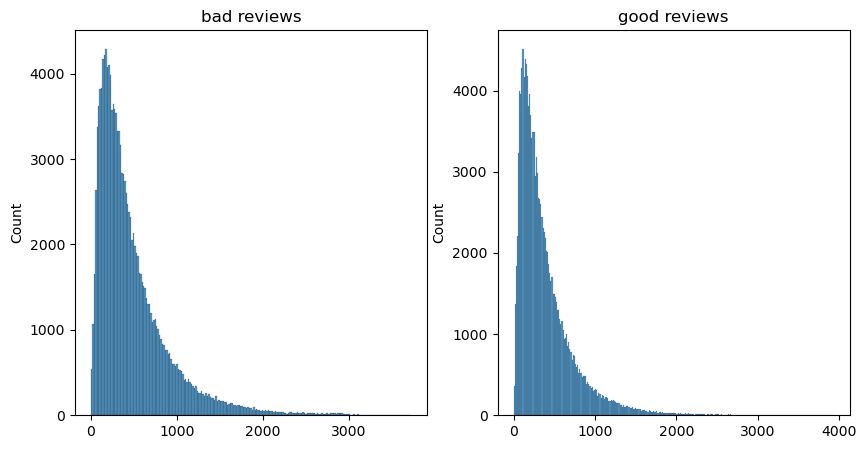

In [8]:
bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(x = bad_reviews, label = 'bad reviews', ax = ax1)
ax1.set_title('bad reviews')
sns.histplot(x = good_reviews, label = 'good reviews', ax = ax2)
ax2.set_title('good reviews')
plt.show()

review
2    140222
1    139778
Name: count, dtype: int64


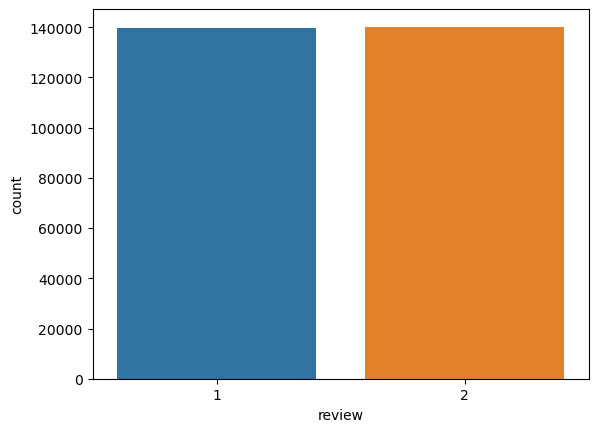

In [9]:
print(eda_df['review'].value_counts())
sns.countplot(x = eda_df['review'])
plt.show()

# Prepare data

In [10]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label == 1 else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id

In [11]:
X_array = train_df['text'].apply(lambda s: clean_text(s)).values
y_array = train_df['review'].values

(train_tokens, train_ids, train_y, train_lengths), vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

100%|██████████| 280000/280000 [00:09<00:00, 28407.70it/s]


vocab len =  46657


100%|██████████| 280000/280000 [00:07<00:00, 35921.04it/s]


ids shape =  torch.Size([280000, 256])
y shape =  torch.Size([280000])
lengths shape =  torch.Size([280000])


In [12]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=0
tokens=['give', 'two', 'stars', 'good', 'guacamole', 'rest', 'food', 'would', 'get', 'star', 'ni', 'thought', 'impossible', 'mess', 'tacos', 'bland', 'even', 'drown', 'salsa', 'try', 'help', 'even', 'work', 'ni', 'zero', 'plans', 'go', 'back', 'eat', 'would', 'maybe', 'drinks', 'guacamole']
length=33
ids=tensor([  77,   40,  134,    4, 1257,  485,    2,    5,    7,  199,   19,  147,
        1959,  938,  406,  413,   16, 7625,  497,   42,  305,   16,  116,   19,
        1184, 2884,   13,   12,   74,    5,  173,   97, 1257,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   

# Model

In [13]:
class PositionalEncoding(nn.Module):

    def __init__(self, num_hiddens: int, dropout:float = 0, max_len: int = 5000):
        super().__init__()
        assert num_hiddens % 2 == 0, f'num hiddens ({num_hiddens}),has to be even'

        self.dropout = nn.Dropout(dropout)

        self.P = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len).float().unsqueeze(1)
        #N = 10000 as defined in the Attention is All You Need paper
        denom = torch.pow(10000, torch.arange(0, num_hiddens,2).float()/num_hiddens)
        x = x/denom
        self.P[:,:,0::2] = torch.sin(x)
        self.P[:,:,1::2] = torch.cos(x)

        # self.P = self.P.to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # assert x.device == self.P.device, 'in positional encoding, X should have the same device with P'
        batch_size, length, num_hiddens = x.shape
        x = x + self.P[:,:length,:].to(x.device)
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_class, 
    num_heads, dim_fc, num_tokens, device,
    dropout = 0.2, num_encoder_layers = 2, batch_first = True):

        '''
        @params:
            input_size: input features or embedding size
            num_heads: number of multi attentino heads 
            dim_fc:  dimension of feedforward layer
            dropout: drop out rate
            num_tokens: number of tokens in vocabulary (some call vocab_size)
        '''
        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model = input_size,
            nhead = num_heads,
            dim_feedforward= dim_fc,
            dropout = dropout,
            batch_first=batch_first,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=self.encoder_layers, num_layers = num_encoder_layers)
        self.embedding = nn.Embedding(num_tokens, input_size)
        self.input_size = input_size 

        self.fc = nn.Linear(input_size, num_class) 

        self._init_weights()
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def forward(self, src, mask = None):
        batch_size, input_len = src.shape
        
        src = self.embedding(src)
        src = src * math.sqrt(self.input_size)
        src = self.pos_encoder(src)

        if mask == None:
            mask = nn.Transformer.generate_square_subsequent_mask(input_len).to(src.device)

        transformer_output = self.encoder(src, mask)

        # print('transformer output shape = ', transformer_output.shape)
        output = self.fc(transformer_output[:,-1]) 
        # print('fc output shape = ', output.shape)
        return output

In [14]:
input_size = 100 
num_class = 2
num_heads = 5
fc_hidden_size = 5
num_tokens = 1000
    
clf = TransformerClassifier(input_size, num_class, num_heads, fc_hidden_size, num_tokens, device = DEVICE)
clf.to(DEVICE)
# clf.convert_to_device(DEVICE)
X = torch.randint(0,1000,(10,5)).to(DEVICE)

y = clf(X, None)

In [15]:
class YelpReview(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = YelpReview(train_ids, train_y, train_lengths)

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])


BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))

num class =  2
train dataset len =  224000
train dataloader len =  7000
val dataset len =  56000
val dataloader len =  1750


In [16]:
# test model running on dataloader

(sample_ids, sample_y, sample_lengths) = next(iter(train_dataloader)) 
print('id shape = ', sample_ids.shape)
print('label shape = ', sample_y.shape)
print('lengths shape = ', sample_lengths.shape)


id shape =  torch.Size([32, 256])
label shape =  torch.Size([32])
lengths shape =  torch.Size([32])


# Tune function

In [17]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.to(device)
    model.train()
    epoch_losses = []
    epoch_accs = []

    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        label = label.to(device)
        length = length
        # prediction = model(ids, length)
        prediction = model(ids)

        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

        

def evaluate(dataloader, model, criterion, device, earlyStopping):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')
    
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        # prediction = model(ids, length)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        if earlyStopping:
            if loss < previous_number:
                previous_number = loss
                consecutive_count = 0
            else:
                consecutive_count += 1
                max_consecutive = max(max_consecutive, consecutive_count)
                if max_consecutive == 3:
                    print("\nStopping training as Validation Loss stopped improving.")
                break
            
        if earlyStopping:
            if max_consecutive == 5:
                break
            
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model, optimizer, criterion, device, epochs = 10, earlyStopping=False):
    print(f"The model has {model.count_parameters()} trainable parameters")

    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device, earlyStopping)
        # test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        # history["test_losses"].append(test_loss)
        # history["test_accs"].append(test_acc)
        # if test_loss < best_valid_loss:
        #     best_valid_loss = test_loss
        #     torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        # print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

    return history

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    # sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    # sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Pretrained embedding

In [18]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Run transformers

### Dropout Rate

In [19]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5



model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10, device = DEVICE, earlyStopping = False)

plot(history)

output dim =  2
The model has 15201194 trainable parameters


training...:   7%|▋         | 514/7000 [00:15<03:13, 33.45it/s]


KeyboardInterrupt: 

### Dropout Rate + L2 Regularization

In [ ]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
weight_decay = 0.001

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10, device = DEVICE, earlyStopping = False)

plot(history)

### Early Stopping + L2 Regularization + Dropout Rate

In [ ]:
lr = 1e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
weight_decay = 0.001

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout=dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 10, device = DEVICE, earlyStopping = True)

plot(history)

### Exp 2 but more epochs

In [ ]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5
weight_decay = 0.001
epochs = 20

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=  NUM_CLASSES,
    num_heads = 5,
    dim_fc = 64,
    num_tokens = vocab_size,
    device = DEVICE,
    dropout = dropout_rate
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = epochs, device = DEVICE, earlyStopping = False)

plot(history)